In [2]:
using Pkg
Pkg.activate("./")
Pkg.instantiate()

  Activating project at `~/Documents/UCL/3x2_analytical`


In [3]:
using LinearAlgebra
using ForwardDiff
using Plots
using LimberJack
using CSV
using YAML
using NPZ
using PythonCall
sacc = pyimport("sacc");

In [4]:
function make_Cmod(dz_cov, data_cov, model; mode="AD")
    m = size(dz_cov)[1]
    n_cls = size(data_cov)[1]
    T = zeros(n_cls, m)

    if mode == "AD"
        println("Using automatic differentiation to compute T")
        null = zeros(m)
        T = ForwardDiff.jacobian(model, null)
    elseif mode == "FD"
        println("Using finite differences to compute T")
        d = 0.05
        for i in 1:m
            null = zeros(m)
            e = zeros(m)
            e[i] = d
            T[:, i] = (model(null.+e) .- model(null.-e)) ./ (2*d)
        end
    end
    TPT = T * dz_cov * T'
    Cmod = Symmetric(data_cov + TPT)
    return Cmod
end

make_Cmod (generic function with 1 method)

In [5]:
dz_err_wlwl = [0.017, 0.017, 0.013, 0.015]
dz_err_gcgc = [0.007, 0.007, 0.006, 0.01, 0.01]
dz_err_3x2 = [dz_err_wlwl; dz_err_gcgc]

dz_cov_wlwl = diagm(dz_err_wlwl.^2)
dz_cov_gcgc = diagm(dz_err_gcgc.^2)
dz_cov_3x2 = diagm(dz_err_3x2.^2);

## WLWL

In [6]:
sacc_path = "../../PhD/LimberJack.jl/data/FD/cls_FD_covG.fits"
yaml_path_wlwl = "data/DESY1/wlwl.yml"
nz_path = "data/DESY1/nzs/"
sacc_wlwl = sacc.Sacc().load_fits(sacc_path)
yaml_wlwl = YAML.load_file(yaml_path_wlwl)
nz_DESwl__0 = npzread(string(nz_path, "nz_DESwl__0.npz"))
nz_DESwl__1 = npzread(string(nz_path, "nz_DESwl__1.npz"))
nz_DESwl__2 = npzread(string(nz_path, "nz_DESwl__2.npz"))
nz_DESwl__3 = npzread(string(nz_path, "nz_DESwl__3.npz"))
meta_wlwl, files_wlwl = make_data(sacc_wlwl, yaml_wlwl)#;
                        #nz_DESwl__0=nz_DESwl__0,
                        #nz_DESwl__1=nz_DESwl__1,
                        #nz_DESwl__2=nz_DESwl__2,
                        #nz_DESwl__3=nz_DESwl__3);

DESwl__0 DESwl__0 24
DESwl__0 DESwl__1 24
DESwl__0 DESwl__2 24
DESwl__0 DESwl__3 24
DESwl__1 DESwl__1 24
DESwl__1 DESwl__2 24
DESwl__1 DESwl__3 24
DESwl__2 DESwl__2 24
DESwl__2 DESwl__3 24
DESwl__3 DESwl__3 24


(LimberJack.Instructions(["DESwl__0", "DESwl__1", "DESwl__2", "DESwl__3"], Any[["DESwl__0", "DESwl__0"], ["DESwl__0", "DESwl__1"], ["DESwl__0", "DESwl__2"], ["DESwl__0", "DESwl__3"], ["DESwl__1", "DESwl__1"], ["DESwl__1", "DESwl__2"], ["DESwl__1", "DESwl__3"], ["DESwl__2", "DESwl__2"], ["DESwl__2", "DESwl__3"], ["DESwl__3", "DESwl__3"]], ["galaxy_shear", "galaxy_shear", "galaxy_shear", "galaxy_shear"], [0, 24, 48, 72, 96, 120, 144, 168, 192, 216, 240], [2.4659965589802277e-9, 1.937338987992683e-9, 6.992765360481148e-10, -4.9611713239579213e-11, 7.913395793306234e-10, 2.025477514463439e-10, 2.937251108461027e-10, 2.5800941836058233e-10, 3.588061352802992e-10, 6.231168353367879e-10  …  4.737458899576856e-10, 8.27594560926968e-10, 5.318332277673948e-10, 3.860067333751191e-10, 4.674884118894536e-10, 3.737344096265107e-10, 8.676072775051082e-11, 2.8609099937088954e-10, 2.0381853638647756e-10, 1.2493271614464064e-10], [1.470692645100043e-18 -9.214475828663469e-20 … -8.136848663040252e-24 -7.

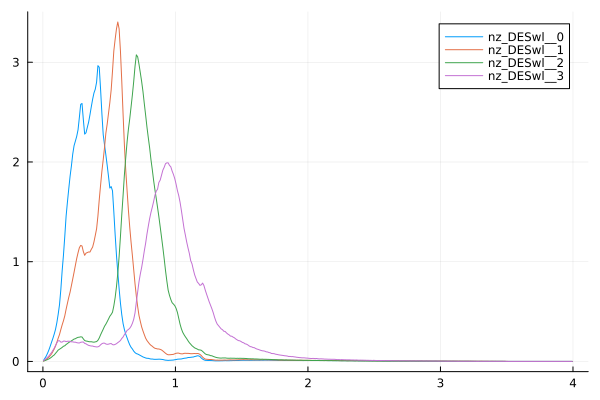

In [14]:
plot(files_wlwl["nz_DESwl__0"][1], files_wlwl["nz_DESwl__0"][2], label="nz_DESwl__0")
plot!(files_wlwl["nz_DESwl__1"][1], files_wlwl["nz_DESwl__1"][2], label="nz_DESwl__1")
plot!(files_wlwl["nz_DESwl__2"][1], files_wlwl["nz_DESwl__2"][2], label="nz_DESwl__2")
plot!(files_wlwl["nz_DESwl__3"][1], files_wlwl["nz_DESwl__3"][2], label="nz_DESwl__3")

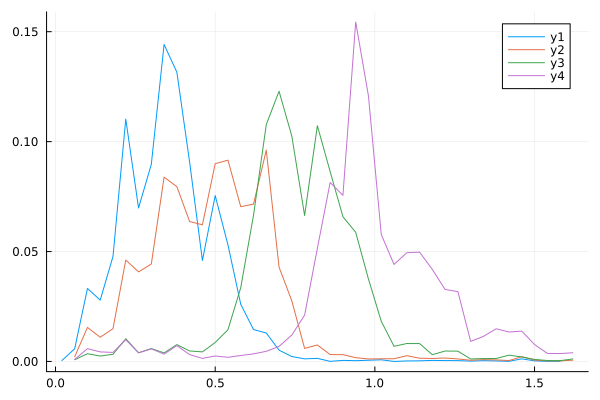

In [10]:
plot(nz_DESwl__0["z"], nz_DESwl__0["dndz"])
plot!(nz_DESwl__1["z"], nz_DESwl__1["dndz"])
plot!(nz_DESwl__2["z"], nz_DESwl__2["dndz"])
plot!(nz_DESwl__3["z"], nz_DESwl__3["dndz"])

In [6]:
function model_wlwl(x; meta=meta_wlwl, files=files_wlwl)
    cosmo = Cosmology(Ωm=0.3, Ωb=0.05, h=0.67, σ8=0.81, ns=0.96,
    tk_mode=:EisHu, pk_mode=:Halofit)
    nuisances = Dict(
        "DESgc__0_b" => 1.484,
        "DESgc__1_b" => 1.805,
        "DESgc__2_b" => 1.776,
        "DESgc__3_b" => 2.168,
        "DESgc__4_b" => 2.23,
        "DESwl__0_dz" => x[1],
        "DESwl__1_dz" => x[2],
        "DESwl__2_dz" => x[3],
        "DESwl__3_dz" => x[4],
        "DESwl__0_m" => 0.018,
        "DESwl__1_m" => 0.014,
        "DESwl__2_m" => 0.01,
        "DESwl__3_m" => 0.004,
        "A_IA" => 0.294,
        "alpha_IA" => 0.378)
    cosmo.settings.cosmo_type = eltype(valtype(x))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [7]:
Cmod_wlwl_FD = make_Cmod(dz_cov_wlwl, meta_wlwl.cov, model_wlwl; mode="FD")
Cmod_wlwl_AD = make_Cmod(dz_cov_wlwl, meta_wlwl.cov, model_wlwl; mode="AD")

Using finite differences to compute T
Using automatic differentiation to compute T


240×240 Symmetric{Float64, Matrix{Float64}}:
  1.54828e-18  -5.19142e-20   3.24383e-20  …  -8.13685e-24  -7.39618e-24
 -5.19142e-20   5.4089e-19   -2.50588e-20     -1.79796e-24  -1.88294e-24
  3.24383e-20  -2.50588e-20   3.10828e-19     -8.56731e-25  -8.93461e-25
  1.83815e-20   1.22806e-20  -1.8582e-20      -4.3922e-25   -4.57366e-25
  1.45827e-20   7.34745e-21   6.09872e-21     -2.58236e-25  -2.74889e-25
  1.17903e-20   6.2174e-21    3.63669e-21  …  -1.66529e-25  -1.8202e-25
  9.99617e-21   5.26855e-21   3.29685e-21     -1.12535e-25  -1.27489e-25
  8.63529e-21   4.5567e-21    2.88604e-21     -7.88128e-26  -9.25381e-26
  7.50388e-21   3.96045e-21   2.50924e-21     -5.62207e-26  -6.64e-26
  6.49337e-21   3.42729e-21   2.18333e-21     -4.44747e-26  -4.27483e-26
  5.67123e-21   2.99441e-21   1.90694e-21  …  -3.19482e-26  -2.94555e-26
  4.92599e-21   2.60199e-21   1.66158e-21     -2.21107e-26  -2.01397e-26
  4.30089e-21   2.27202e-21   1.45223e-21     -1.4983e-26   -1.32242e-26
  ⋮       

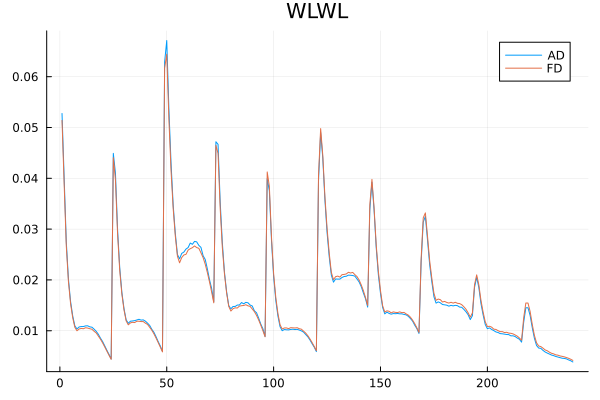

In [8]:
plot(abs.(diag(meta_wlwl.cov) .- diag(Cmod_wlwl_AD)) ./ diag(meta_wlwl.cov), label="AD", title="WLWL")
plot!(abs.(diag(meta_wlwl.cov) .- diag(Cmod_wlwl_FD)) ./ diag(meta_wlwl.cov), label="FD", title="WLWL")

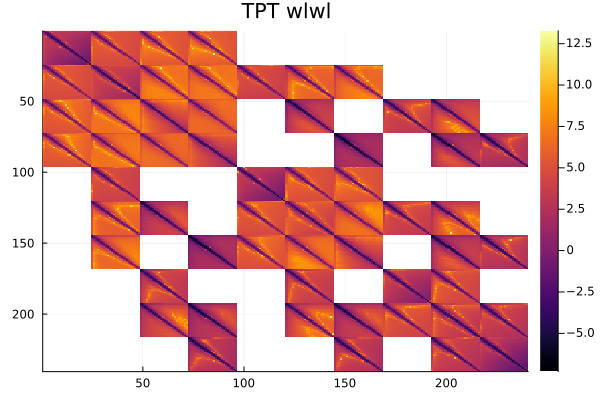

In [9]:
heatmap(log.(abs.((Cmod_wlwl_AD .- meta_wlwl.cov)./ meta_wlwl.cov)), title="TPT wlwl", yflip=true)

In [10]:
npzwrite("covs/dz_wlwl_covs.npz",
        Dict(
        "wlwl_AD" => Cmod_wlwl_AD,
        "wlwl_FD" => Cmod_wlwl_FD))

## GCGC

In [15]:
sacc_path = "../../PhD/LimberJack.jl/data/FD/cls_FD_covG.fits"
yaml_path_gcgc = "data/DESY1/gcgc.yml"
nz_path = "data/DESY1/nzs/"
sacc_gcgc = sacc.Sacc().load_fits(sacc_path)
yaml_gcgc = YAML.load_file(yaml_path_gcgc)
nz_DESgc__0 = npzread(string(nz_path, "nz_DESgc__0.npz"))
nz_DESgc__1 = npzread(string(nz_path, "nz_DESgc__1.npz"))
nz_DESgc__2 = npzread(string(nz_path, "nz_DESgc__2.npz"))
nz_DESgc__3 = npzread(string(nz_path, "nz_DESgc__3.npz"))
nz_DESgc__4 = npzread(string(nz_path, "nz_DESgc__4.npz"))
meta_gcgc, files_gcgc = make_data(sacc_gcgc, yaml_gcgc)#;
                                  #nz_DESgc__0=nz_DESgc__0,
                                  #nz_DESgc__1=nz_DESgc__1,
                                  #nz_DESgc__2=nz_DESgc__2,
                                  #nz_DESgc__3=nz_DESgc__3,
                                  #nz_DESgc__4=nz_DESgc__4);

DESgc__0 DESgc__0 5
DESgc__1 DESgc__1 8
DESgc__2 DESgc__2 10
DESgc__3 DESgc__3 11
DESgc__4 DESgc__4 13


(LimberJack.Instructions(["DESgc__0", "DESgc__1", "DESgc__2", "DESgc__3", "DESgc__4"], Any[["DESgc__0", "DESgc__0"], ["DESgc__1", "DESgc__1"], ["DESgc__2", "DESgc__2"], ["DESgc__3", "DESgc__3"], ["DESgc__4", "DESgc__4"]], ["galaxy_density", "galaxy_density", "galaxy_density", "galaxy_density", "galaxy_density"], [0, 5, 13, 23, 34, 47], [0.00019024248750512107, 7.391276663994371e-5, 4.261252890607883e-5, 2.22965965139283e-5, 2.176880112868429e-5, 8.240734039668606e-5, 8.421314587773898e-5, 2.6585137640401017e-5, 2.6033426315289483e-5, 1.6202481595102046e-5  …  1.720793463317388e-5, 1.876041365219758e-5, 1.1858834397319835e-5, 6.023987322753388e-6, 3.4894299563905405e-6, 7.420152296134288e-6, 4.729410691534381e-6, 4.317808418665961e-6, 4.736098712055406e-6, 2.545509196409628e-6], [3.503459378925734e-9 -2.6907237994012596e-10 … -1.8766243449428733e-32 -1.9859652134651026e-32; -2.6907237994012596e-10 2.4651642374142706e-10 … -4.810041560235908e-31 -4.501051455667023e-31; … ; -1.87662434494

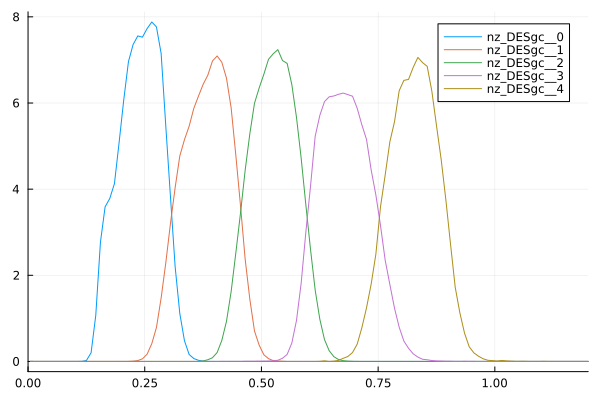

In [20]:
plot(files_gcgc["nz_DESgc__0"][1], files_gcgc["nz_DESgc__0"][2], label="nz_DESgc__0")
plot!(files_gcgc["nz_DESgc__1"][1], files_gcgc["nz_DESgc__1"][2], label="nz_DESgc__1")
plot!(files_gcgc["nz_DESgc__2"][1], files_gcgc["nz_DESgc__2"][2], label="nz_DESgc__2")
plot!(files_gcgc["nz_DESgc__3"][1], files_gcgc["nz_DESgc__3"][2], label="nz_DESgc__3")
plot!(files_gcgc["nz_DESgc__4"][1], files_gcgc["nz_DESgc__4"][2], xlim=[0., 1.2], label="nz_DESgc__4")


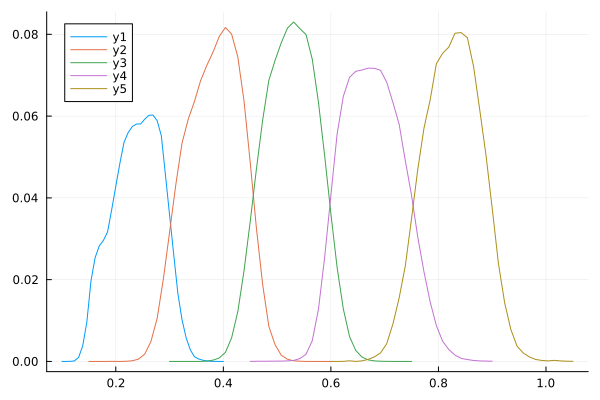

In [16]:
plot(nz_DESgc__0["z"], nz_DESgc__0["dndz"])
plot!(nz_DESgc__1["z"], nz_DESgc__1["dndz"])
plot!(nz_DESgc__2["z"], nz_DESgc__2["dndz"])
plot!(nz_DESgc__3["z"], nz_DESgc__3["dndz"])
plot!(nz_DESgc__4["z"], nz_DESgc__4["dndz"])

In [12]:
function model_gcgc(x; meta=meta_gcgc, files=files_gcgc)
    cosmo = Cosmology(Ωm=0.3, Ωb=0.05, f=0.67, σ8=0.81, ns=0.96,
    tk_mode=:EisHu, pk_mode=:Halofit)
    nuisances = Dict(
        "DESgc__0_b" => 1.484,
        "DESgc__1_b" => 1.805,
        "DESgc__2_b" => 1.776,
        "DESgc__3_b" => 2.168,
        "DESgc__4_b" => 2.23,
        "DESgc__0_dz" => x[1],
        "DESgc__1_dz" => x[2],
        "DESgc__2_dz" => x[3],
        "DESgc__3_dz" => x[4],
        "DESgc__4_dz" => x[5],
        "DESwl__0_m" => 0.018,
        "DESwl__1_m" => 0.014,
        "DESwl__2_m" => 0.01,
        "DESwl__3_m" => 0.004,
        "A_IA" => 0.294,
        "alpha_IA" => 0.378)
    cosmo.settings.cosmo_type = eltype(valtype(x))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [13]:
Cmod_gcgc_FD = make_Cmod(dz_cov_gcgc, meta_gcgc.cov, model_gcgc; mode="FD")
Cmod_gcgc_AD = make_Cmod(dz_cov_gcgc, meta_gcgc.cov, model_gcgc; mode="AD")

Using finite differences to compute T
Using automatic differentiation to compute T


47×47 Symmetric{Float64, Matrix{Float64}}:
  3.62254e-9   -2.38178e-10   2.01023e-11  …  -1.87662e-32  -1.98597e-32
 -2.38178e-10   2.54532e-10  -1.54334e-11     -4.81004e-31  -4.50105e-31
  2.01023e-11  -1.54334e-11   4.55024e-11     -6.62644e-30  -5.57972e-30
 -3.37992e-12   1.43071e-12  -3.20829e-12      2.297e-30     1.7355e-30
  4.981e-13     1.38992e-13   3.06705e-13      2.08106e-30   1.86978e-30
  2.01833e-11  -1.49487e-12   3.77291e-14  …  -3.58921e-31  -1.68264e-31
 -1.49487e-12   1.90349e-12  -1.4405e-13      -1.86466e-30  -5.14008e-31
  3.77291e-14  -1.4405e-13    3.66309e-13     -4.78034e-30  -3.86025e-30
 -3.9064e-14    2.45717e-15  -3.01034e-14      2.28857e-30   2.45617e-30
 -1.24511e-14  -4.81249e-15   1.87693e-16      6.42016e-30   3.31707e-30
 -8.505e-15    -1.80644e-15  -1.09959e-15  …   4.94903e-30   4.03354e-30
 -5.64903e-15  -1.17089e-15  -4.62843e-16     -1.95881e-30   1.00323e-30
 -3.29647e-15  -8.86067e-16  -3.13327e-16     -1.01577e-30   2.27371e-30
  ⋮      

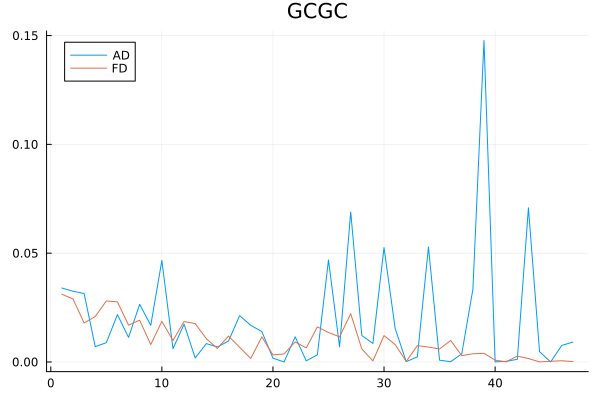

In [14]:
plot(abs.(diag(meta_gcgc.cov) .- diag(Cmod_gcgc_AD)) ./ diag(meta_gcgc.cov), label="AD", title="GCGC")
plot!(abs.(diag(meta_gcgc.cov) .- diag(Cmod_gcgc_FD)) ./ diag(meta_gcgc.cov), label="FD")

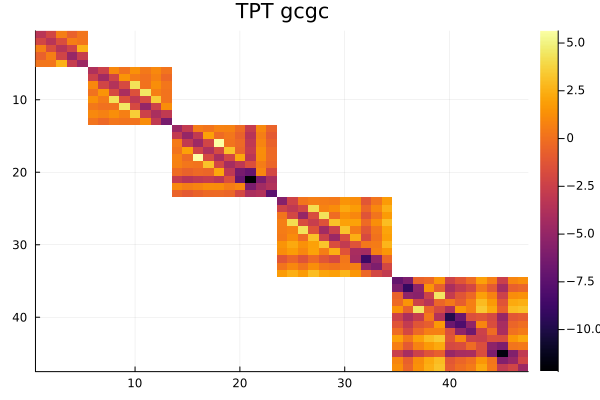

In [15]:
heatmap(log.(abs.((Cmod_gcgc_AD .- meta_gcgc.cov)./ meta_gcgc.cov)), title="TPT gcgc", yflip=true)

In [16]:
npzwrite("covs/dz_wlwl_covs.npz",
        Dict(
        "gcgc_AD" => Cmod_gcgc_AD,
        "gcgc_FD" => Cmod_gcgc_FD))

## 3x2

In [17]:
sacc_path = "../../PhD/LimberJack.jl/data/FD/cls_FD_covG.fits"
yaml_path_3x2 = "data/DESY1/gcgc_gcwl_wlwl.yml"
sacc_3x2 = sacc.Sacc().load_fits(sacc_path)
yaml_3x2 = YAML.load_file(yaml_path_3x2)
#nz_DESwl__0 = npzread(string(nz_path, "nz_DESwl__0.npz"))
#nz_DESwl__1 = npzread(string(nz_path, "nz_DESwl__1.npz"))
#nz_DESwl__2 = npzread(string(nz_path, "nz_DESwl__2.npz"))
#nz_DESwl__3 = npzread(string(nz_path, "nz_DESwl__3.npz"))
#nz_DESgc__0 = npzread(string(nz_path, "nz_DESgc__0.npz"))
#nz_DESgc__1 = npzread(string(nz_path, "nz_DESgc__1.npz"))
#nz_DESgc__2 = npzread(string(nz_path, "nz_DESgc__2.npz"))
#nz_DESgc__3 = npzread(string(nz_path, "nz_DESgc__3.npz"))
#nz_DESgc__4 = npzread(string(nz_path, "nz_DESgc__4.npz"))
meta_3x2, files_3x2 = make_data(sacc_3x2, yaml_3x2,
                                nz_DESwl__0=nz_DESwl__0,
                                nz_DESwl__1=nz_DESwl__1,
                                nz_DESwl__2=nz_DESwl__2,
                                nz_DESwl__3=nz_DESwl__3,
                                nz_DESgc__0=nz_DESgc__0,
                                nz_DESgc__1=nz_DESgc__1,
                                nz_DESgc__2=nz_DESgc__2,
                                nz_DESgc__3=nz_DESgc__3,
                                nz_DESgc__4=nz_DESgc__4);

DESgc__0 DESgc__0 5
DESgc__1 DESgc__1 8
DESgc__2 DESgc__2 10
DESgc__3 DESgc__3 11
DESgc__4 DESgc__4 13
DESgc__0 DESwl__0 5
DESgc__0 DESwl__1 5
DESgc__0 DESwl__2 5
DESgc__0 DESwl__3 5
DESgc__1 DESwl__0 8
DESgc__1 DESwl__1 8
DESgc__1 DESwl__2 8
DESgc__1 DESwl__3 8
DESgc__2 DESwl__0 10
DESgc__2 DESwl__1 10
DESgc__2 DESwl__2 10
DESgc__2 DESwl__3 10
DESgc__3 DESwl__0 11
DESgc__3 DESwl__1 11
DESgc__3 DESwl__2 11
DESgc__3 DESwl__3 11
DESgc__4 DESwl__0 13
DESgc__4 DESwl__1 13
DESgc__4 DESwl__2 13
DESgc__4 DESwl__3 13
DESwl__0 DESwl__0 24
DESwl__0 DESwl__1 24
DESwl__0 DESwl__2 24
DESwl__0 DESwl__3 24
DESwl__1 DESwl__1 24
DESwl__1 DESwl__2 24
DESwl__1 DESwl__3 24
DESwl__2 DESwl__2 24
DESwl__2 DESwl__3 24
DESwl__3 DESwl__3 24
using custom nz for nz_DESgc__0
using custom nz for nz_DESgc__1
using custom nz for nz_DESgc__2
using custom nz for nz_DESgc__3
using custom nz for nz_DESgc__4
using custom nz for nz_DESwl__0
using custom nz for nz_DESwl__1
using custom nz for nz_DESwl__2
using custom nz for

In [18]:
function model_3x2(x; meta=meta_3x2, files=files_3x2)
    cosmo = Cosmology(Ωm=0.3, Ωb=0.05, h=0.67, σ8=0.81, ns=0.96,
    tk_mode=:EisHu, pk_mode=:Halofit)
    nuisances = Dict(
        "DESgc__0_b" => 1.484,
        "DESgc__1_b" => 1.805,
        "DESgc__2_b" => 1.776,
        "DESgc__3_b" => 2.168,
        "DESgc__4_b" => 2.23,
        "DESwl__0_dz" => x[1],
        "DESwl__1_dz" => x[2],
        "DESwl__2_dz" => x[3],
        "DESwl__3_dz" => x[4],
        "DESgc__0_dz" => x[5],
        "DESgc__1_dz" => x[6],
        "DESgc__2_dz" => x[7],
        "DESgc__3_dz" => x[8],
        "DESgc__4_dz" => x[9],
        "DESwl__0_m" => 0.018,
        "DESwl__1_m" => 0.014,
        "DESwl__2_m" => 0.01,
        "DESwl__3_m" => 0.004,
        "A_IA" => 0.294,
        "alpha_IA" => 0.378) 
    cosmo.settings.cosmo_type = eltype(valtype(x))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [19]:
Cmod_3x2_FD = make_Cmod(dz_cov_3x2, meta_3x2.cov, model_3x2; mode="FD");
Cmod_3x2_AD = make_Cmod(dz_cov_3x2, meta_3x2.cov, model_3x2; mode="AD");

Using finite differences to compute T
Using automatic differentiation to compute T


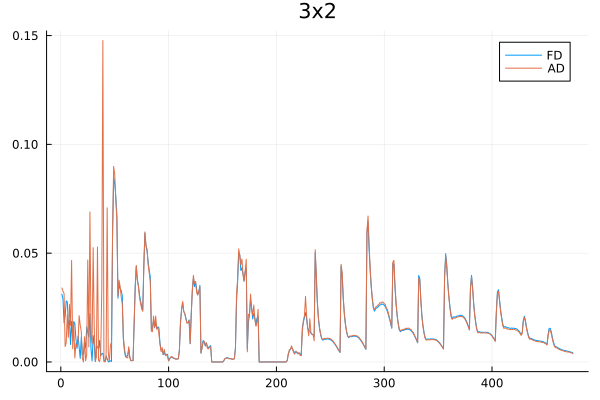

In [20]:
plot(abs.(diag(meta_3x2.cov) .- diag(Cmod_3x2_FD)) ./ diag(meta_3x2.cov), label="FD", title="3x2")
plot!(abs.(diag(meta_3x2.cov) .- diag(Cmod_3x2_AD)) ./ diag(meta_3x2.cov), label="AD")

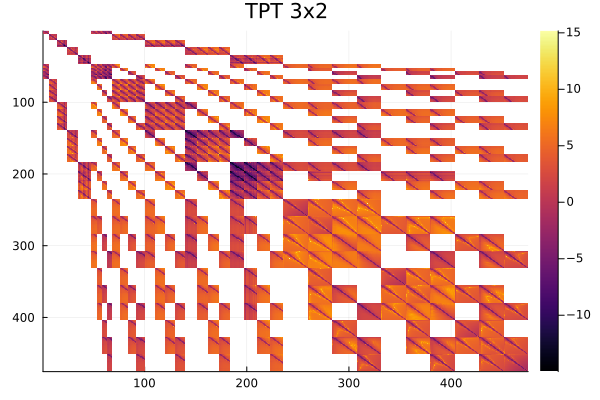

In [21]:
heatmap(log.(abs.((Cmod_3x2_AD .- meta_3x2.cov)./ meta_3x2.cov)), title="TPT 3x2", yflip=true)

In [22]:
npzwrite("covs/dz_3x2_covs.npz",
        Dict(
        "3x2_AD" => Cmod_3x2_AD,
        "3x2_FD" => Cmod_3x2_FD))

## Save

In [23]:
using NPZ
npzwrite("covs/dz_covs.npz",
        Dict(
        "wlwl_AD" => Cmod_wlwl_AD,
        "wlwl_FD" => Cmod_wlwl_FD,
        "gcgc_AD" => Cmod_gcgc_AD,
        "gcgc_FD" => Cmod_gcgc_FD,
        "3x2_AD" => Cmod_3x2_AD,
        "3x2_FD" => Cmod_3x2_FD))